In [2]:
import os
import tqdm
import time

In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import random

def set_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if torch.backends.mps.is_available():
        device = 'mps'
device = set_device()

def to_torch(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(1)

In [5]:
proj_dir = './'
inp_dir = proj_dir + 'in_dir/'
style_dir = inp_dir + '/style/'
content_dir = inp_dir + '/content/'
out_dir = proj_dir + '/out_dir/'

In [6]:
def get_file_name(name, size):
    return '{0}_{1}'.format(name, size)

PILtoTensor = transforms.PILToTensor()

def read_img(img_name, img_dir = 'in_dir/', grayscale=False, r=None):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img) / 255
    if r:
        img = np.rot90(img, k=r)
    return img

toPIL = lambda x: transforms.ToPILImage()(x.cpu())

def save_tb_img(fname, img_out, out_dir=out_dir):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    # im = trans(img_out)
    im = Image.fromarray(img_out)
    im.save(full_name)

def save_img(fname, img_out, out_dir = out_dir):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img = np.clip(img_out.numpy(), a_min=0, a_max=1)
    img = (img*255).astype(np.uint8)
    im = Image.fromarray(img)
    # im = toPIL(img_out)
    im.save(full_name)
    # plt.imsave(full_name, img_out)

In [7]:
starry_night = get_file_name('starry_night', 'small')
neckarfront = get_file_name('Tuebingen_Neckarfront', size='small')

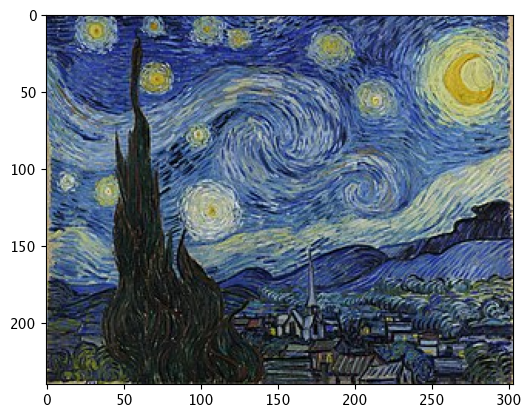

In [8]:
starry_night_img = read_img(starry_night, style_dir)
plt.imshow(starry_night_img)

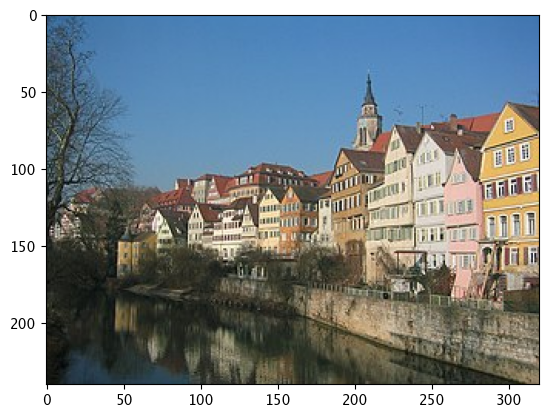

In [9]:
neckarfront_img = read_img(neckarfront, content_dir)
plt.imshow(neckarfront_img)

In [10]:
imagenet_mean = torch.tensor([0.4, 0.456, 0.406], device=device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device)
# imagenet_std = torch.tensor([1,1,1], device=device)

denorm = transforms.Normalize(mean=-imagenet_mean.view(1,1,-1), std=1/imagenet_std.view(1,1,-1))
torch_trans = lambda x: to_torch(x).moveaxis(-1, 0).unsqueeze(0)

def normalize_min_max(img):
    c_min = img.flatten(start_dim=0, end_dim=1).min(0).values
    c_max = img.flatten(start_dim=0, end_dim=1).max(0).values
    return (img - c_min) / (c_max - c_min)

def undo_norm(x, mean, std):
    m, s = mean.view(1,1,-1), std.view(1,1,-1)
    return (x*s) + m

def normalize(x):
    if x.ndim == 4:
        axes = [2,3]
        mean, std = x.mean(axis=axes).view(-1,1,1), x.std(axis=axes).view(-1,1,1)
    elif x.shape[0] == 3:
        axes = [1,2]
        mean, std = x.mean(axis=axes).view(-1,1,1), x.std(axis=axes).view(-1,1,1)
    else:
        axes = [0,1]
        mean, std = x.mean(axis=axes), x.std(axis=axes)
    return (x-mean)/(std), mean, std

In [11]:
class VGG19AvgPool(nn.Module):
    def __init__(self, content, style, 
                 content_weight=1, style_weight=1000, 
                 take_norm=True, clone=True):
        super(VGG19AvgPool, self).__init__()        
        self.style_layers = [0, 5, 10, 19, 28] # conv1-1, conv2-1, conv3-1, conv4-1, conv5-1
        self.content_layers = [21] # conv4-2
        self.content_weight, self.style_weight = content_weight, style_weight
        self.layer_to_style_weight = {layer_num: 1/([0.1,10,10,10,0.1][i]) for i,layer_num in enumerate(self.style_layers)}
        # self.layer_to_style_weight = {layer_num: 1/5 for i,layer_num in enumerate(self.style_layers)}

        self.loss = 0
        self.normalize = take_norm
        self.content = to_torch(content).moveaxis(-1, 0).unsqueeze(0)
        self.style = to_torch(style).moveaxis(-1, 0).unsqueeze(0)
        
        self.transform = transforms.Compose([
            # transforms.Normalize(mean=imagenet_mean.view(-1,1,1), std=imagenet_std.view(-1,1,1)),
            transforms.Resize(size=self.content.shape[2], antialias=True)
        ])
        if self.normalize:
            self.content, self.content_mean, self.content_std = normalize(self.content)
            # self.content = self.transform(self.content)
            self.style, self.style_mean, self.style_std = normalize(self.style)
            self.style = self.transform(self.style)
            # self.content, self.style = self.transform(self.content), self.transform(self.style)
        canvas = self.content.clone().contiguous() if clone else torch.randn_like(self.content, device=device).contiguous()
        self.canvas = nn.Parameter(canvas)
        self.optimizer = torch.optim.LBFGS([self.canvas])
        self.style_targets = {}
        self.content_targets = {}
        
        self.model = nn.Sequential()
        self.build_model()
        self.freeze()

    # Create model from VGG-19
    def build_model(self):
        vgg_model = torchvision.models.vgg19(
            weights=torchvision.models.VGG19_Weights.DEFAULT
        ).features
        
        style_x, content_x = self.style, self.content
        for i, layer in enumerate(vgg_model.children()):
            # Replace MaxPool with AvgPool for better results
            if isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(
                    kernel_size=layer.kernel_size, 
                    stride=layer.stride
                )
            elif isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
                
            self.model.add_module(str(i), layer)
            
            # Setup targets
            with torch.no_grad():
                style_x, content_x = layer(style_x), layer(content_x)
                
            if i in self.style_layers:
                self.style_targets[i] = self.gram_matrix(style_x)
            elif i in self.content_layers:
                self.content_targets[i] = content_x.detach().clone()

            # Remove extra layers
            if i == max(self.style_layers):
                break
    
    # Freeze all parameters
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
    
    def content_loss(self, generated, target):
        return F.mse_loss(generated, target)
    
    def gram_matrix(self, x):
        b, c, h, w = x.size()
        feature_mat = x.view(b, c, h*w)
        gram_mat = torch.bmm(feature_mat, feature_mat.transpose(1,2))
        return gram_mat.div(h*w)
    
    def style_loss(self, generated, gram_target):
        gram_gen = self.gram_matrix(generated)
        return F.mse_loss(gram_gen, gram_target)
    
    def content_loss_weight(self, i):
        return 1/len(self.content_layers) #1
    
    def style_loss_weight(self, i):
        return self.layer_to_style_weight[i]
        # return 1/len(self.style_layers) #1/5
    
    def forward(self, canvas):
        style_loss = 0
        content_loss = 0
        for i, layer in enumerate(self.model.children()):
            canvas = layer(canvas)
            if i in self.style_layers:
                loss = self.style_loss(canvas, self.style_targets[i])
                style_loss += loss * self.style_loss_weight(i)
            elif i in self.content_layers:
                loss = self.content_loss(canvas, self.content_targets[i])
                content_loss += loss * self.content_loss_weight(i)

        # total_loss = self.content_weight * content_loss + self.style_weight * style_loss
        return style_loss, content_loss
    
    def get_img_for_vis(self, apply_denorm=True):
        generated = self.canvas.detach().squeeze(0).moveaxis(0,-1)
        return undo_norm(generated, self.style_mean, self.style_std) if apply_denorm else generated
    
    def train(self, max_iter=500, log_iter=10, vis_iter=5, tb_sum_writer=None):
        num_iter = 0
        while num_iter < max_iter:
            def closure():
                nonlocal num_iter
                self.optimizer.zero_grad()
                # self.canvas.clamp(-1, 1)
                style_loss, content_loss = self.forward(self.canvas)
                total_loss = self.content_weight * content_loss + self.style_weight * style_loss
                total_loss.backward()
                self.loss = total_loss.cpu().item()
                if num_iter % log_iter == 0:
                    print("Iter {0}: Total Loss {1}, Content Loss: {2}, Style Loss: {3}".format(
                        num_iter, self.loss, content_loss.cpu().item(), style_loss.cpu().item())
                    )
                if tb_sum_writer:
                    if num_iter % vis_iter == 0:
                        tb_sum_writer.add_image('Generated img', self.get_img_for_vis().moveaxis(-1,0), num_iter)
                        tb_sum_writer.add_scalar("Content Loss", content_loss.cpu().item(), num_iter)
                        tb_sum_writer.add_scalar("Style Loss", style_loss.cpu().item(), num_iter)
                        tb_sum_writer.add_scalar("Total Loss", self.loss, num_iter)
                num_iter += 1

                return total_loss
            
            self.optimizer.step(closure)

In [12]:
def stats(im):
    print('mean: ', im.mean(axis=[0,1]))
    print('std: ', im.std(axis=[0,1]))
    print('max: ', im.flatten(start_dim=0, end_dim=1).max(0).values)
    print('min: ', im.flatten(start_dim=0, end_dim=1).min(0).values)

In [18]:
vgg19_avgpool = VGG19AvgPool(
    content=read_img(get_file_name('nyc', 'medium'), content_dir),
    style=read_img(get_file_name('starry_night', 'medium'), style_dir),
    content_weight=1,
    style_weight=1000,
    clone=True
).to(device)

In [ ]:
fname = 'neckarfront_{2}_{1}_{0}_{3}_ss'.format(content_weight, style, size, style_weight) + time.strftime("%d-%m-%Y_%H-%M-%S")
tb_writer = SummaryWriter(log_dir=logs_dir+fname)
vgg19_avgpool.train(log_iter=50)

In [20]:
vgg19_avgpool.loss

31.04569435119629

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean:  tensor([0.3016, 0.3633, 0.4352])
std:  tensor([0.1789, 0.1885, 0.1956])
max:  tensor([1.0250, 1.1016, 1.0259])
min:  tensor([-0.2543, -0.3959, -0.2405])
31.04569435119629


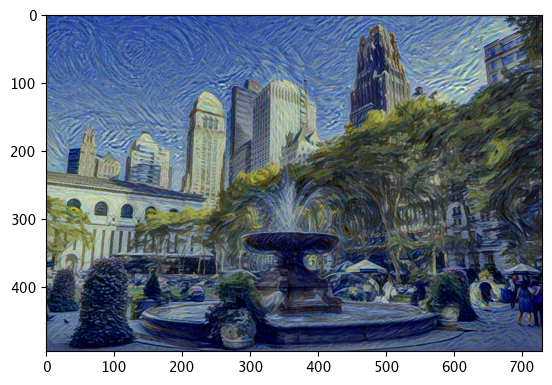

In [21]:
plt.imshow(vgg19_avgpool.get_img_for_vis(True))
stats((vgg19_avgpool.get_img_for_vis(True)))
print(vgg19_avgpool.loss)

In [161]:
save_img(
    fname='test_ship_large_1000_1',
    img_out=vgg19_avgpool.get_img_for_vis(True),
    out_dir=out_dir+'/neckarfront'
)

In [23]:
styles = ['starry_night', 'femme','shipwreck', 'composition', 'scream']

In [28]:
size = 'medium'
c = 'japan_rz'
content_weight = 1
logs_dir = proj_dir + '/logdir/'
style_weight = 100000
for style in styles:
    style_img = read_img(get_file_name(style, 'medium'), style_dir)
    fname = c+'_{2}_{1}_{0}_{3}'.format(content_weight, style, size, style_weight) + time.strftime("%d-%m-%Y_%H-%M-%S")
    tb_writer = SummaryWriter(log_dir=logs_dir+fname)
    print('Training ', fname)
    vgg19_avgpool = VGG19AvgPool(
        content=read_img(get_file_name(c, size), content_dir), 
        style=style_img,
        content_weight=content_weight,
        style_weight=style_weight
    ).to(device)
    vgg19_avgpool.train(max_iter=190, log_iter=50, tb_sum_writer=tb_writer)
    save_img(
        fname=fname,
        img_out=vgg19_avgpool.get_img_for_vis(True),
        out_dir=out_dir+'/'+c+'/'
    )

Training  japan_rz_medium_starry_night_1_10000010-12-2023_22-57-04
Iter 0: Total Loss 539253.875, Content Loss: 0.0, Style Loss: 5.392539024353027
Iter 50: Total Loss 1309.90478515625, Content Loss: 8.303207397460938, Style Loss: 0.013016016222536564
Iter 100: Total Loss 446.75115966796875, Content Loss: 8.823287963867188, Style Loss: 0.004379278514534235
Iter 150: Total Loss 261.4837341308594, Content Loss: 9.092599868774414, Style Loss: 0.0025239114183932543
Training  japan_rz_medium_femme_1_10000010-12-2023_23-00-25
Iter 0: Total Loss 706091.1875, Content Loss: 0.0, Style Loss: 7.060912132263184
Iter 50: Total Loss 2614.49462890625, Content Loss: 8.701606750488281, Style Loss: 0.026057928800582886
Iter 100: Total Loss 758.19140625, Content Loss: 9.05861759185791, Style Loss: 0.0074913278222084045
Iter 150: Total Loss 351.4174499511719, Content Loss: 9.187150955200195, Style Loss: 0.0034223028924316168
Training  japan_rz_medium_shipwreck_1_10000010-12-2023_23-03-42
Iter 0: Total Loss

In [165]:
size = 'large'
c = 'Tuebingen_Neckarfront'
for content_weight in [10**i for i in range(0,2)]:
    for style in styles:
        style_img = read_img(get_file_name(style, size), style_dir)
        fname = 'neckarfront_{2}_{1}_{0}_final_simple'.format(content_weight, style, size)
        print('Training ', fname)
        vgg19_avgpool = VGG19AvgPool(
            content=read_img(get_file_name('Tuebingen_Neckarfront', size), content_dir), 
            style=style_img,
            content_weight=content_weight,
            style_weight=1000
        ).to(device)
        vgg19_avgpool.train(log_iter=100)
        save_img(
            fname=fname,
            img_out=vgg19_avgpool.get_img_for_vis(True),
            out_dir=out_dir+'/neckarfront'
        )

Training  neckarfront_large_shipwreck_1_final_simple
Iter 0: Total Loss 4084.8818359375, Content Loss: 0.0, Style Loss: 4.084881782531738
Iter 100: Total Loss 4.757533073425293, Content Loss: 4.056496620178223, Style Loss: 0.0007010364206507802
Iter 200: Total Loss 3.9465975761413574, Content Loss: 3.4758517742156982, Style Loss: 0.0004707459011115134
Iter 300: Total Loss 3.675326108932495, Content Loss: 3.2381725311279297, Style Loss: 0.00043715364881791174
Iter 400: Total Loss 3.5436172485351562, Content Loss: 3.119269371032715, Style Loss: 0.0004243477887939662
Training  neckarfront_large_femme_1_final_simple
Iter 0: Total Loss 3719.72265625, Content Loss: 0.0, Style Loss: 3.7197227478027344
Iter 100: Total Loss 7.998000621795654, Content Loss: 4.286226749420166, Style Loss: 0.003711773781105876
Iter 200: Total Loss 4.541999340057373, Content Loss: 3.595627784729004, Style Loss: 0.0009463714668527246
Iter 300: Total Loss 3.8593502044677734, Content Loss: 3.2625253200531006, Style Lo

KeyboardInterrupt: 

In [ ]:
tran = transforms.Compose([
            transforms.Normalize(mean=-imagenet_mean.view(-1,1,1), std=imagenet_std.view(-1,1,1)),
            transforms.Resize(size)
        ])
t = torch.rand((3, 100,200))
tran(t)

In [118]:
save_img(
    fname=fname,
    img_out=vgg19_avgpool.get_img_for_vis(),
    out_dir=out_dir+'/neckarfront'
)

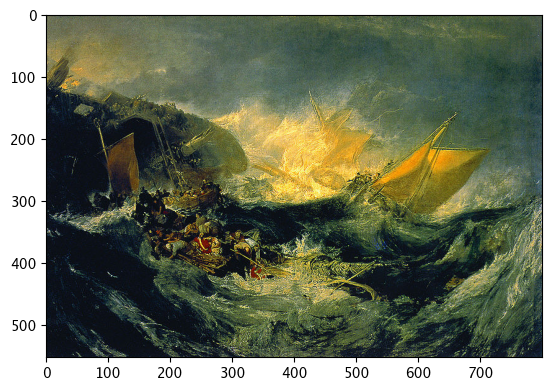

In [32]:
plt.imshow(style_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


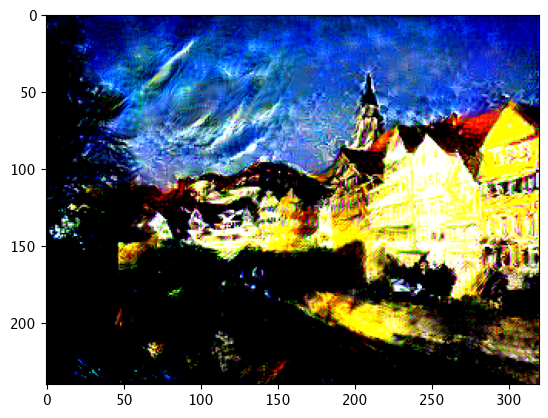

In [33]:
generated = (vgg19_avgpool.get_img_for_vis(False))
g = undo_norm(generated, (vgg19_avgpool.style_mean+vgg19_avgpool.content_mean)/2, (vgg19_avgpool.style_std+vgg19_avgpool.content_std)/2)
plt.imshow(generated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


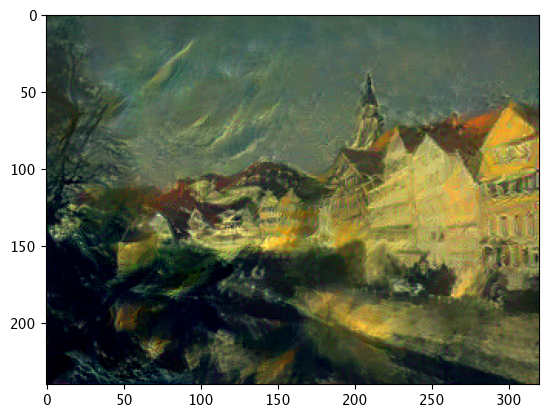

In [30]:
generated = (vgg19_avgpool.get_img_for_vis(False))
g = undo_norm(generated, (vgg19_avgpool.style_mean), (vgg19_avgpool.style_std))
plt.imshow(g)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


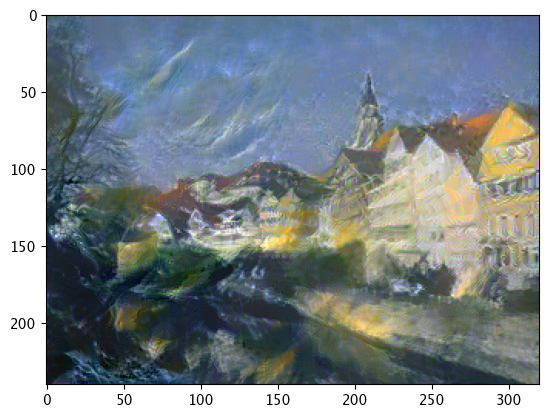

In [31]:
generated = (vgg19_avgpool.get_img_for_vis(False))
g = undo_norm(generated, (vgg19_avgpool.content_mean), (vgg19_avgpool.content_std))
plt.imshow(g)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


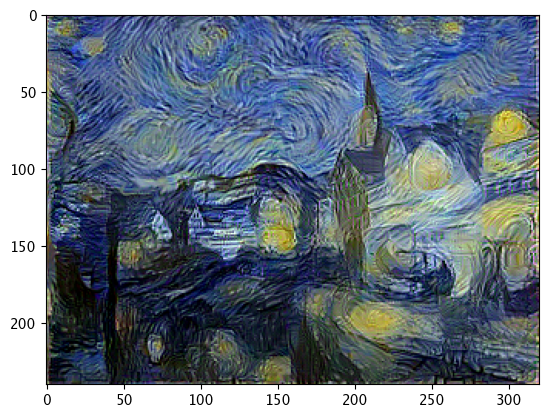

In [85]:
generated_100 = (vgg19_avgpool.get_img_for_vis())
plt.imshow(generated_100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


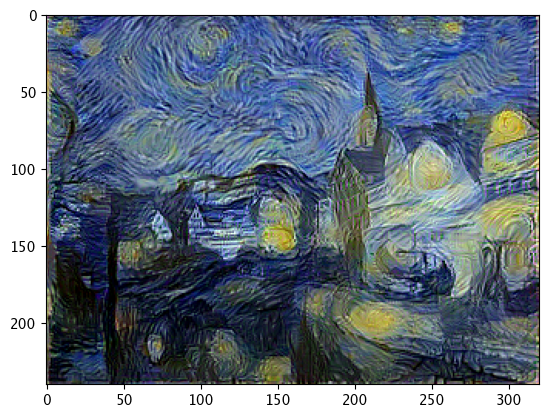

In [81]:
generated_1000 = (vgg19_avgpool.get_img_for_vis())
plt.imshow(generated_1000)

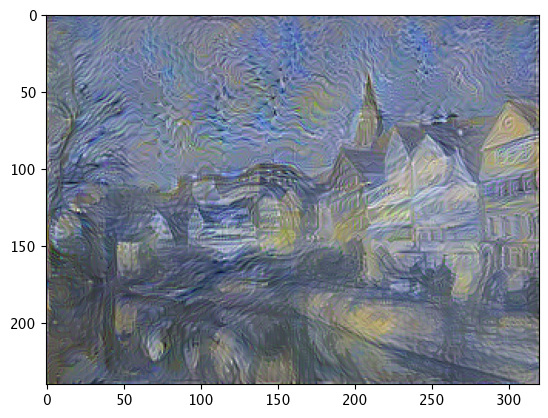

In [92]:
generated = normalize_img(vgg19_avgpool.get_img_for_vis())
plt.imshow(generated)

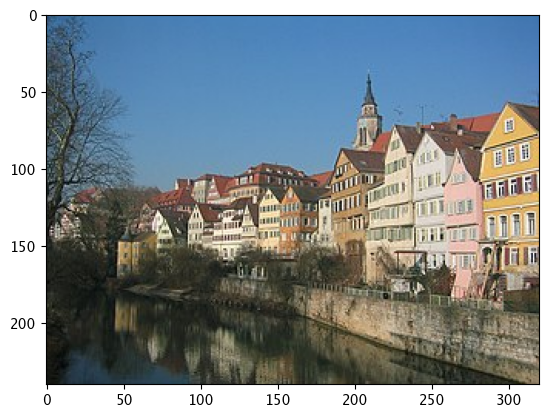

In [66]:
plt.imshow(normalize_img(to_torch(neckarfront_img)))

tensor([1.0283, 1.1161, 1.1280])

In [29]:
denorm(vgg19_avgpool.canvas.detach().squeeze(0).moveaxis(0,-1)).mean(axis=[0,1])

tensor([0.1606, 0.1836, 0.1888])

In [33]:
(vgg19_avgpool.canvas.detach().squeeze(0).moveaxis(0,-1)).min()

tensor(-0.2867)

In [234]:
vgg19_avgpool.canvas.detach().mean(), vgg19_avgpool.canvas.detach().min(), vgg19_avgpool.canvas.detach().max()

(tensor(0.3642), tensor(0.), tensor(1.))

In [ ]:
vgg19_avgpool.canvas.detach().mean(), vgg19_avgpool.canvas.detach().min(), vgg19_avgpool.canvas.detach().max()

In [68]:
next(vgg19_avgpool.model.children())

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))